In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import pdb

## 【問題1】不純度を求める関数
ノード の ジニ不純度 を計算する関数を作成してください。ノード $ t $ に対するジニ不純度 $ I(t) $ は以下の数式で求まります。クラスが混じり合っているほどジニ不純度は高くなります。
$$
I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}
$$

## 【問題2】情報利得を求める関数
次に、ノード間の 情報利得 を計算する関数を作成してください。問題1で作成したジニ不純度 $ I(t) $ を計算する関数を呼び出して使います。  
情報利得 $ IG $ は以下の数式で求まります。うまく分けられている時ほど情報利得は大きくなります。  

ここで分岐は2つのみであるため、分岐先を「左側のノード・右側のノード」と呼びます。  

$$
IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)
$$

## 【問題3】学習
空間の分割を行い、決定木のグラフを生成するコードを作成してください。今は深さ1の決定木なので、分割を1回だけ行います。ここでグラフを生成するとは、1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求めるということです。  

訓練データに対して全ての組み合わせの分割を行い、その中でノード間の情報利得が最大となる分割をそのノードの分割基準として記録します。  

クラスが混ざらない不純度が0のノード、または指定された深さのノードが 葉ノード となります。葉ノードにはクラスを記録しておき、これを推定時に分類するクラスとします。クラスが混ざらない場合はそのままのクラスを記録し、混ざっている場合は多数決により決めます。

## 【問題4】推定
推定する仕組みを実装してください。ScratchDecesionTreeClassifierDepth1クラスの雛形に含まれるpredictメソッドに書き加えてください。  

入力されたデータの値を学習した条件で判定していき、どの葉ノードに到達するかを見ます。葉ノードにはクラスが記録されているので、これが推定値となります。

In [3]:
class ScratchDecesionTreeClassifierDepth1():
   
    def __init__(self, max_depth=1, verbose=False):
        # ハイパーパラメータを属性として記録
        self.max_depth = max_depth
        self.verbose = verbose
        
        self.X, self.y = None, None
        
    def fit(self, X, y):
        
        self.X = X
        self.y = y
        root_labels, root_label_nums = np.unique(self.y, return_counts=True)
        self.node_nums = root_label_nums
        
        max_ig = 0
        self.col, self.value = 0, 0
        self.under_label, self.over_label = None, None
        
        for i in range(self.X.shape[1]):
            data = X[:,i]
            thresholds = np.linspace(np.min(data), np.max(data), 5)
            for threshold in thresholds:
                under_idx = np.where(data<threshold)[0]
                over_idx = np.where(data>=threshold)[0]
                _, under_label_nums = np.unique(self.y[under_idx], return_counts=True)
                _, over_label_nums = np.unique(self.y[over_idx], return_counts=True)
                tmp_ig = self._info_gain(self.node_nums, under_label_nums, over_label_nums)
                if max_ig < tmp_ig:
                    max_ig = tmp_ig
                    self.col, self.value = i, threshold
                    self.under_label = stats.mode(self.y[under_idx])[0][0]
                    self.over_label = stats.mode(self.y[over_idx])[0][0]
                          
                
    def _gini(self, node):
        if len(node) == 0:
            return 0
        return 1 - np.sum(node**2)/np.sum(node)**2
    
    def _info_gain(self, node, left, right):
        if len(node) == 0:
            return 0
        ig = self._gini(node) - (np.sum(left)*self._gini(left) + np.sum(right*self._gini(right)))/np.sum(node)
        return ig
    
    def predict(self, X):
        y_pred = np.where(X[:,self.col]<self.value, self.under_label, self.over_label)
        return y_pred

## 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット2の2値分類に対してスクラッチ実装の学習と推定を行なってください。

In [4]:
X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

#### scratch

In [5]:
scratch = ScratchDecesionTreeClassifierDepth1()
scratch.fit(X_train, y_train)

In [6]:
y_pred = scratch.predict(X_test)
accuracy_score(y_pred, y_test)

0.4

#### sklearn.tree.DecisionTreeClassifier

In [7]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=1)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [8]:
y_pred = tree.predict(X_test)
accuracy_score(y_pred, y_test)

0.5

## 【問題6】決定領域の可視化
決定領域を可視化してください。

In [9]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X_train, y_train, model, step=0.01, target_names=['0', '1']):

    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step), 
                                    np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title('dicision region')
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.contourf(mesh_f0, mesh_f1, pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y_train)):
        plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

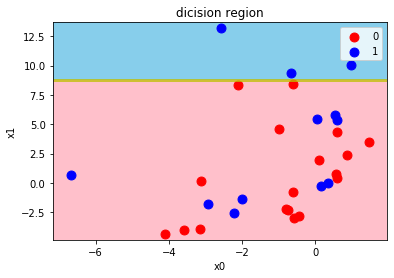

In [10]:
decision_region(X_train, y_train, scratch)

## 【問題8】深さに制限のない決定木分類器クラスの作成
深さに制限のない決定木分類器のクラスScratchDecesionTreeClassifierDepthInfを作成してください。  

任意の深さを指定できるようにするとともに、指定しない場合は全ての葉ノードがジニ不純度0となるまで続けられるようにもしてください。

In [11]:
class ScratchDecesionTreeClassifier():
   
    def __init__(self, max_depth=1, verbose=False):
        # ハイパーパラメータを属性として記録
        self.max_depth = max_depth

        
    def fit(self, X, y):
        self.path = []
        self.threshold = []
        self.label = []
        self.depth = []
        self.cols = []
        self.tree(X, y, None, 0, [], [], [])
          

    def tree(self, X, y, label, depth, cols, path, threshold):
        if (depth >= self.max_depth):
            #print('label',label, 'depth',depth, 'col',cols, 'path',path, 'th',threshold)
            self.path.append(path)
            self.label.append(label)
            self.depth.append(depth)
            self.threshold.append(threshold)
            self.cols.append(cols)
            return

        
        root_labels, root_label_nums = np.unique(y, return_counts=True)
        under_label, over_label = None, None
      
        for i in range(X.shape[1]):
            xs = X[:,i]
            x_minimum, x_maximum = np.min(xs), np.max(xs)
            max_ig = 0
            for x in xs:
                under_idx = np.where(xs<x)[0]
                over_idx = np.where(xs>=x)[0]
                _, under_label_nums = np.unique(y[under_idx], return_counts=True)
                _, over_label_nums = np.unique(y[over_idx], return_counts=True)
                tmp_ig = self._info_gain(root_label_nums, under_label_nums, over_label_nums)
                if x != x_minimum and max_ig < tmp_ig:
                #if (x != x_minimum and x != x_maximum) and max_ig < tmp_ig:
                    max_ig = tmp_ig
                    col, value = i, x
                    under_label = stats.mode(y[under_idx])[0][0]
                    over_label = stats.mode(y[over_idx])[0][0]
                    under = under_idx
                    over = over_idx
                else:
                    continue
        if max_ig == 0:
            #print(label, depth, cols, path, threshold)
            self.path.append(path)
            self.label.append(label)
            self.depth.append(depth)
            self.threshold.append(threshold)
            self.cols.append(cols)
            return
        
        self.tree(np.copy(X[under]), np.copy(y[under]),
                  under_label, depth+1, cols+[col,], path+[1,], threshold+[value,])
        self.tree(np.copy(X[over]), np.copy(y[over]), 
                  over_label, depth+1, cols+[col,], path+[2,], threshold+[value,])
        return

                
    def _gini(self, node):
        if len(node) == 0:
            return 0
        return 1 - np.sum(node**2)/np.sum(node)**2
    
    def _info_gain(self, node, left, right):
        if len(node) == 0:
            return 0
        ig = self._gini(node) - (np.sum(left)*self._gini(left) + np.sum(right*self._gini(right)))/np.sum(node)
        return ig
    
    def predict(self, X):
        y_pred = np.empty(len(X))
        for i in range(len(X)):
            for j in range(len(self.path)):
                label, depth = self.label[j], self.depth[j]
                cols, threshold, path = self.cols[j], self.threshold[j], self.path[j]
                for d in range(depth):
                    if ((X[i,cols[d]]<threshold[d]) and (path[d]==1)) or ((X[i,cols[d]]>=threshold[d]) and (path[d]==2)):
                        if d+1 == depth:
                            y_pred[i] = label
                        continue
                    else:
                        break
        return y_pred
    

In [12]:
scratch = ScratchDecesionTreeClassifier(max_depth=15)
scratch.fit(X_train, y_train)

In [13]:
y_pred2 = scratch.predict(X_test)

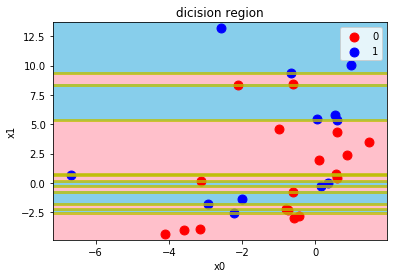

In [14]:
decision_region(X_train, y_train, scratch)